In [1]:
import os
import glob
import numpy as np
from pyhail import hdr, mesh_grid, mesh_ppi, common, hsda, hacc
import pyart
from datetime import datetime
from urllib import request

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#configurations for HSDA retrieval
hca_hail_idx = [6, 7, 8] #list of hail classe(s) indices in HCA
dzdr         = 0 #ZDR offset (used to correct calibration)
radar_band   = 'S'

#grid configuration required for calculating MESH
grid_shape  = (41, 201, 201)
grid_limits = ((0, 20000), (-100000.0, 100000.0), (-100000.0, 100000.0))
grid_roi    = 2000

#plotting
max_lat = -37.7
min_lat = -38
max_lon = 145.3
min_lon = 145.0
n_grid_lines = 5
cb_lon = 145.073439
cb_lat = -37.845574
subplot_nrows = 3
subplot_ncols = 4
label_offset = 0.005

In [3]:
def _adjust_ncarpid_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the hydrometeor classification.
    """
    cb.set_ticks(np.linspace(0.5, 19.5, 20))
    cb.ax.set_yticklabels(
        [
        "nodata","Cloud","Drizzle","Light_Rain","Moderate_Rain","Heavy_Rain",
           "Hail","Rain_Hail_Mixture","Graupel_Small_Hail","Graupel_Rain",
           "Dry_Snow", "Wet_Snow", "Ice_Crystals", "Irreg_Ice_Crystals",
           "Supercooled_Liquid_Droplets", "Flying_Insects", "Second_Trip", "Ground_Clutter",
           "misc1", "misc2"
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb


def _adjust_hsda_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the HSDA classification.
    """
    cb.set_ticks(np.linspace(0, 3, 4))
    cb.ax.set_yticklabels(
        [
            "None",
            "SH (<25mm)",
            "LH (25-50mm)",
            "GH (>50mm)",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def build_cmaps():
    """
    This function retruns the discrete colourmaps used in the pipeline
    """
    hca_colors = [
        "White", #no data
        "lightgray", #cloud
        "LightBlue", #drizzle
        "SteelBlue", #light rain
        "RoyalBlue", #moderate rain
        "Navy", #heavy rain
        "fuchsia", #hail
        "darkviolet", #rain hail
        "hotpink", #Graupel_Small_Hail
        "crimson", #Graupel_Rain
        "lightgreen", #Dry_Snow 
        "limegreen", #Wet_Snow
        "green", #Ice_Crystals
        "seagreen", #Irreg_Ice_Crystals
        "Red", #Supercooled_Liquid_Droplets
        "orange", #Flying_Insects
        "chocolate", #Second_Trip
        "sienna", #Ground_Clutter
        "cyan", #misc1
        "teal", #misc2 
        ]
    hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
    hca_cmap = colors.ListedColormap(hca_colors)  
    hsda_cmap = colors.ListedColormap(hsda_colors) 
    return hca_cmap, hsda_cmap

In [4]:
def pipeline(radar_file_name, tilt, close_fig=True):
    
    def _create_ppi_plot(subplot_idx, fieldname, tilt, vmin, vmax, cmap=None, title=None):
        """
        subplot creation function
        """
        #create subplot axis
        ax=plt.subplot(subplot_ncols,subplot_nrows,subplot_idx, projection=ccrs.PlateCarree())
        #add radar dataax=ax,
        if cmap is None:
            display.plot_ppi_map(fieldname,tilt, vmin=vmin, vmax=vmax, resolution = '10m', ax=ax,
                                 max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                                 lat_lines = lat_lines, lon_lines = lon_lines)
        else:
            display.plot_ppi_map(fieldname,tilt, vmin=vmin, vmax=vmax, resolution = '10m', ax=ax,
                                 max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                                 lat_lines = lat_lines, lon_lines = lon_lines,
                                 cmap=cmap)
        #create marker for point
        display.plot_point(cb_lon, cb_lat, 'k+', 'Observed 60mm', label_offset=[label_offset, label_offset])
        #add title
        if title is not None:
            plt.set_title(title)
    
    ###########################################################
    # Preprocessing
    ###########################################################
    
    #load radar object
    try:
        if ".h5" in radar_fn:
            radar = pyart.aux_io.read_odim_h5(radar_fn)
        elif ".nc" or ".mdv" in radar_fn:
            radar = pyart.io.read(radar_fn)
    except:
        print('file failed: ',radar_fn)
        return None
    #load instrument data
    radar_name = radar.metadata['instrument_name']
    #extract date    
    dt       = datetime.strptime(radar.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

    #build sounding data
    snd_data = np.load(sounding_fn)
    #dry bulb calcs for MESH
    dbt_minus20C = common.sounding_interp(snd_data["t"], snd_data["z"],-20)
    dbt_0C       = common.sounding_interp(snd_data["t"], snd_data["z"],0)
    #wet bulb calcs for HSDA
    snd_wbt      = common.wbt(snd_data["t"],snd_data["r"])
    wbt_minus25C = common.sounding_interp(snd_wbt,snd_data["z"],-25)
    wbt_0C       = common.sounding_interp(snd_wbt,snd_data["z"],0)
    
    ###########################################################
    # MESH Volumetric Hail Size Retrieval
    ###########################################################    
    
    #MESH
    meshppi_fields = mesh_ppi.main(radar, 'corrected_reflectivity', levels=[dbt_0C, dbt_minus20C], min_range=10, max_range=150,
                 mesh_method='mh2019_75', radar_band=radar_band)
    radar.add_field('mesh_mh2019_75', meshppi_fields['mesh_mh2019_75'], replace_existing=True)
    
    
    ###########################################################
    # Polarimetric Hail Size Retrievals
    ###########################################################
    
    #HSDA
    hsda_meta = hsda.main(radar, [wbt_0C, wbt_minus25C], hca_hail_idx)
    #filter HSDA (demonstrate filter)
    hsda_meta['data'] = common.filter_small_objects(hsda_meta['data'], threshold=0, size=9)
    radar.add_field('hsda', hsda_meta, replace_existing=True) 
    
    #HDR
    #build radar data dict
    dbz = radar.fields['corrected_reflectivity']['data']
    zdr = radar.fields['corrected_differential_reflectivity']['data']
    radar_dict = {'dbz':dbz, 'zdr':zdr}
    hdr_meta, hdr_size_meta = hdr.main(radar_dict)
    radar.add_field('hdr', hdr_meta, replace_existing=True)
    radar.add_field('hdr_size', hdr_size_meta, replace_existing=True)
    
    #hAcc (hail accumulation)
    pressure_correction = 853 #specific to this case, see reference paper in lash module to calculate your own.
    hacc_meta = hacc.main(radar, wbt_0C, pressure_correction,
        z_fname='corrected_reflectivity', hsda_fname='hsda', mesh_fname='mesh_mh2019_75')
    radar.add_field('hacc', hacc_meta, replace_existing=True)

    ###########################################################
    # Plotting for PPI
    ###########################################################
 
    hca_cmap, hsda_cmap = build_cmaps()
    
    fig = plt.figure(figsize=[16,20])
    lat_lines = np.linspace(min_lat, max_lat, n_grid_lines)
    lon_lines = np.linspace(min_lon, max_lon, n_grid_lines)
    display = pyart.graph.RadarMapDisplay(radar)
    
    _create_ppi_plot(1, 'corrected_reflectivity', tilt, -20, 70)
    
    _create_ppi_plot(2, 'signal_to_noise_ratio', tilt, -20, 30)
    
    _create_ppi_plot(3, 'corrected_differential_reflectivity', tilt, -1, 6)
        
    _create_ppi_plot(4, 'corrected_differential_phase', tilt, 0, 90)
    
    _create_ppi_plot(5, 'cross_correlation_ratio', tilt, 0.8, 1.05)

    _create_ppi_plot(6, 'radar_echo_classification', tilt, 0, 20, cmap=hca_cmap)
    display.cbs[-1] = _adjust_ncarpid_scheme_colorbar_for_pyart(display.cbs[-1])
        
    _create_ppi_plot(7, 'mesh_mh2019_75', 0, 0, 50, cmap='hot_r') #MESH always in first level (single PPI product)
    
    _create_ppi_plot(8, 'hsda', tilt, -0.5, 3.5, cmap=hsda_cmap)
    display.cbs[-1] = _adjust_hsda_scheme_colorbar_for_pyart(display.cbs[-1])    
    
    _create_ppi_plot(9, 'hdr_size', tilt, 0, 50, cmap='hot_r')
    
    _create_ppi_plot(10, 'hacc', 0, 0, 0.2, cmap='Greens') #hAcc always in first level (single PPI product)
    #hAcc
    
    ###########################################################
    # Generated gridded reflectivity for MESH and plot
    ###########################################################
    
    #genreate grid object for cts fields
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        weighting_function = 'Barnes',
        gridding_algo = 'map_gates_to_grid',
        roi_func='constant', constant_roi = grid_roi,
        fields=['corrected_reflectivity'])
    
    ###########################################################
    # MESH Gridded Hail Size Retrieval
    ###########################################################
    meshgrid_fields = mesh_grid.main(grid, dbz_fname='corrected_reflectivity', levels=[dbt_0C, dbt_minus20C], mesh_method='mh2019_75', radar_band=radar_band)
    grid.add_field('mesh_mh2019_75', meshgrid_fields['mesh_mh2019_75'], replace_existing=True)
    ###########################################################
    # Plotting for Grids
    ###########################################################
    
    #plot MESH MH2019
    ax=plt.subplot(4,3,11, projection=ccrs.PlateCarree())
    display_grid = pyart.graph.GridMapDisplay(grid)
    display_grid.plot_grid('mesh_mh2019_75', 0, vmin=0, vmax=50, ax = ax, cmap='hot_r',
                           lat_lines = lat_lines, lon_lines = lon_lines)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('Gridded MESH mh2019_75')
    #save to file
    plt.savefig(f'{out_path}/example_tilt{tilt:02}.jpeg', dpi=75)
    
    if close_fig:
        plt.close('all')

In [5]:
#download example datasets
radar_url  = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/02_20200119_051228_ppi.nc'
strm_url = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/melb_500m_dem.tif' #not used in notebook, but can be applied using wradlib to calculate beamblock for HSDA
sounding_url = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/melb_20200119_era5_sounding.npz'
tmp_path    = '/tmp/pyhail_example_data'
if not os.path.exists(tmp_path):
    os.makedirs(tmp_path)
sounding_fn = f'{tmp_path}/melb_20200119_era5_sounding.npz'
radar_fn    = f'{tmp_path}/02_20200119_051228_ppi.nc' #This example is from the Melbourne (Laverton Radar) at 0512UTC on the 19th Jan 2020
request.urlretrieve(radar_url, radar_fn)
request.urlretrieve(sounding_url, sounding_fn)

#define output path
out_path    = '~/pyhail_output_data'
if not os.path.exists(out_path):
    os.makedirs(out_path)

elapsed time: 44.00555086135864 s


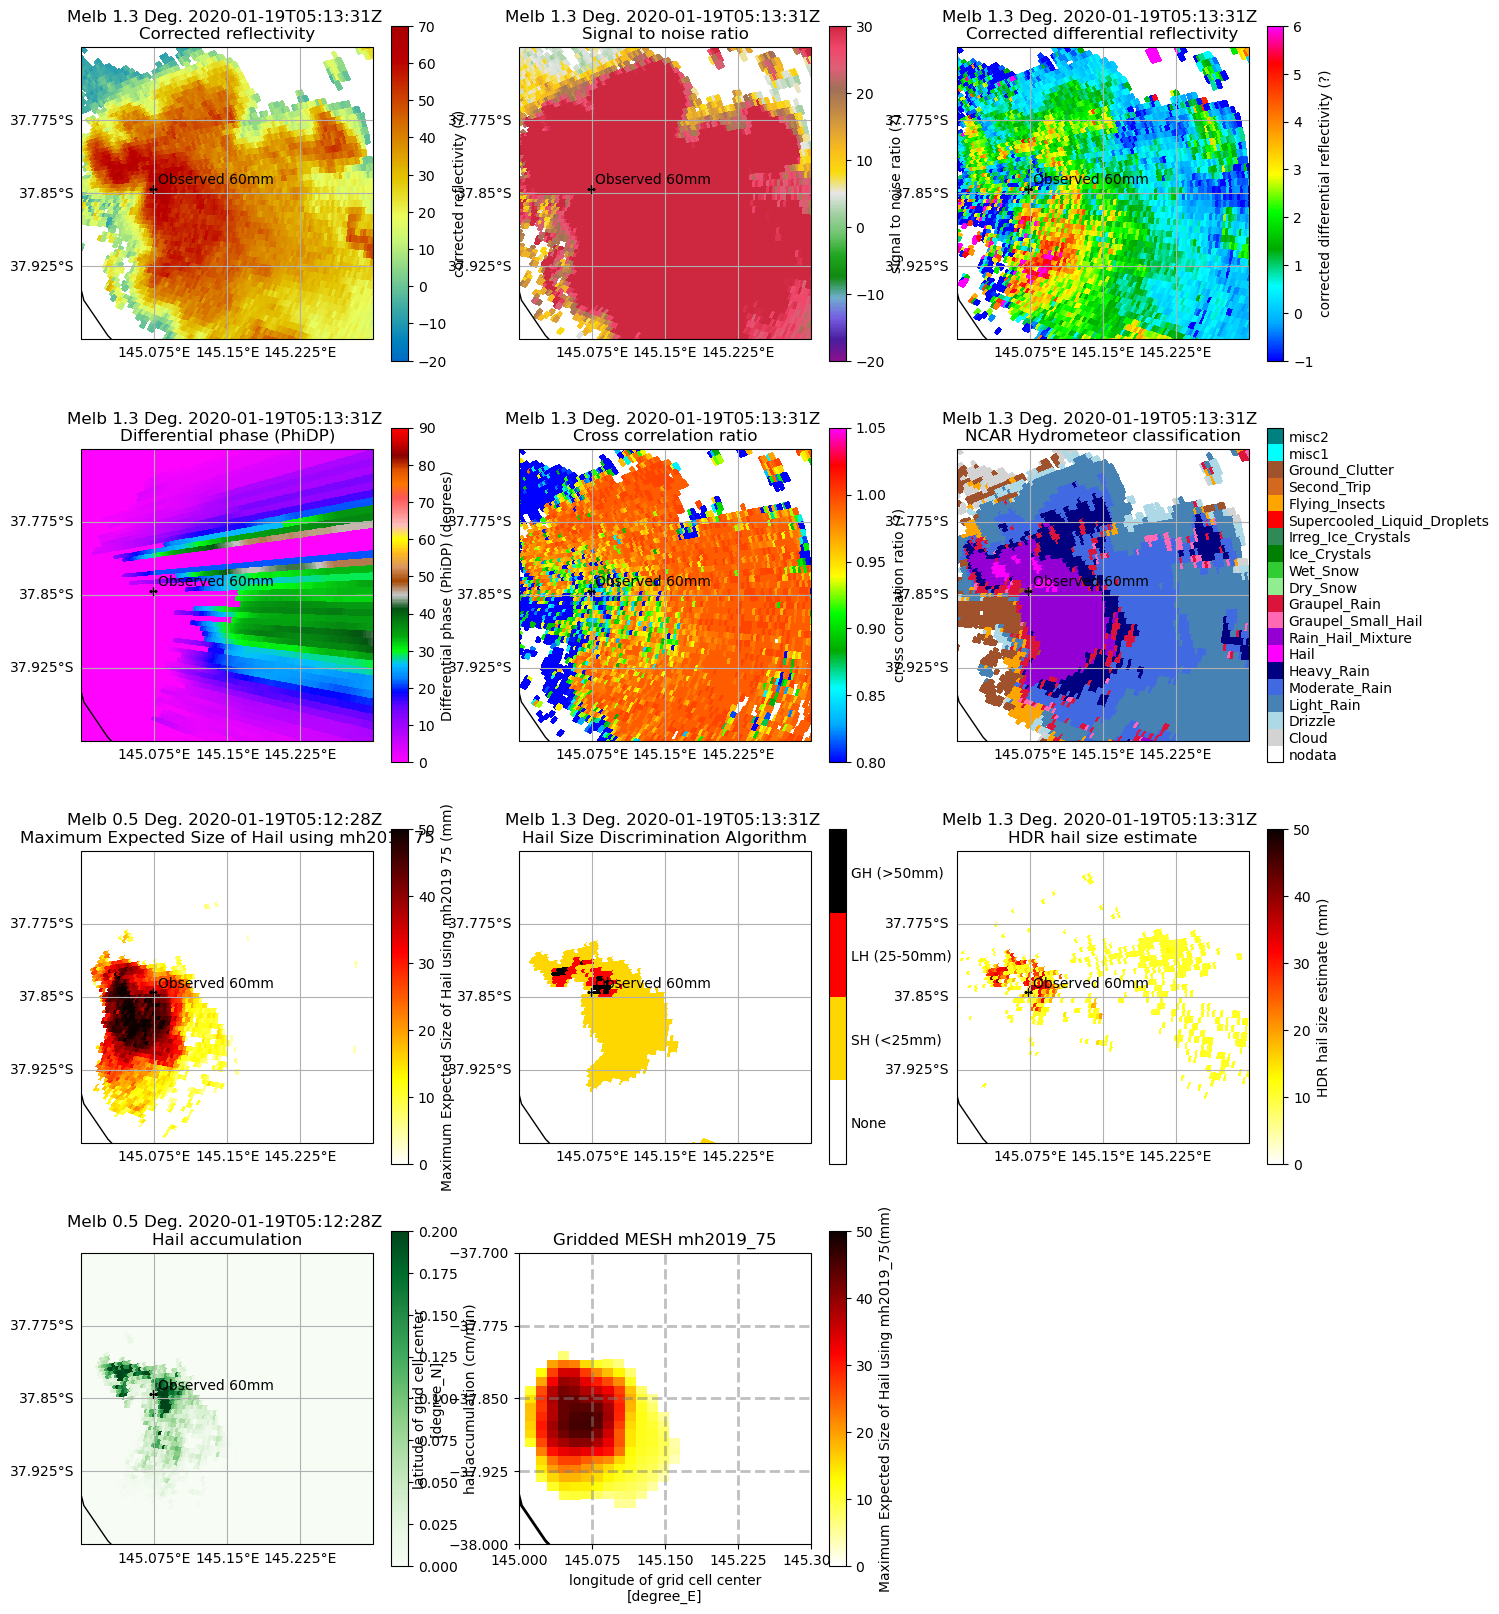

In [6]:
#run pipeline for a single tilt (may not be the lowest sweep)
import time
t0 = time.time()
pipeline(radar_fn, 2, close_fig=False)    
t1 = time.time()
print('elapsed time:', t1-t0, 's')

In [ ]:
#run pipeline for several tilts (close figure, save to file only)
for tilt in range(0,5):
    print('processing for', tilt)
    pipeline(radar_fn, tilt, close_fig=True)

processing for 0
processing for 1
processing for 2
processing for 3
